In [1]:
import pandas as pd

data = pd.read_csv('data_sample_three_years.csv')

data = data.iloc[:, [0,1,2,3,4]]
data.rename(columns={'date': 'open', 'low':'close', 'open':'high', 'high':'low'}, inplace=True)

data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.iloc[:, [0,5,1,2,3,4]]

data_backup = data.loc[ data.timestamp >= 1675814400 ]
data = data.loc[ data.timestamp < 1675814400 ]

from talib import RSI
data['rsi_14'] = RSI(data['close'], timeperiod=14)
data['rsi_14'] = data['rsi_14'].shift(1)

from talib import MA, SMA, EMA
data['ma_9'] = MA(data['close'], timeperiod=9)
data['ma_9'] = data['ma_9'].shift(1)

from talib import MACD
data['macd'], data['signal'], data['hist'] = MACD(data['close'])
data['macd'] = data['macd'].shift(1)
data['signal'] = data['signal'].shift(1)
data['hist'] = data['hist'].shift(1)

from talib import ADX
data['adx'] = ADX(data['high'], data['low'], data['close'])
data['adx'] = data['adx'].shift(1)

data.dropna(axis=0, inplace=True)

In [2]:
data['close+'] = data['close'].shift(1)

data['close_roc'] = ( data['close'] - data['close'].shift(1) ) / data['close'].shift(1)
data['close_roc'] = data['close_roc'].shift(1)
data['rsi_14_roc'] = ( data['rsi_14'] - data['rsi_14'].shift(1) ) / data['rsi_14'].shift(1)
data['rsi_14_roc'] = data['rsi_14_roc'].shift(1)
data['ma_9_roc'] = ( data['ma_9'] - data['ma_9'].shift(1) ) / data['ma_9'].shift(1)
data['ma_9_roc'] = data['ma_9_roc'].shift(1)

data['close_roll'] = data['close+'].rolling(window=14).mean()
data['rsi_14_roll'] = data['rsi_14'].rolling(window=14).mean()
data['ma_9_roll'] = data['ma_9'].rolling(window=14).mean()

data.dropna(axis=0, inplace=True)

In [3]:
data.columns, data.shape

(Index(['timestamp', 'date', 'open', 'high', 'low', 'close', 'rsi_14', 'ma_9',
        'macd', 'signal', 'hist', 'adx', 'close+', 'close_roc', 'rsi_14_roc',
        'ma_9_roc', 'close_roll', 'rsi_14_roll', 'ma_9_roll'],
       dtype='object'),
 (16214, 19))

In [4]:
best_features = ('macd', 'signal', 'hist', 'adx', 'close+', 'close_roc', 'ma_9_roc', 'close_roll', 'rsi_14_roll', 'ma_9_roll')

In [5]:
inputs = data[list(best_features)]
target = data.iloc[:, [5]]

In [6]:
inputs

,macd,signal,hist,adx,close+,close_roc,ma_9_roc,close_roll,rsi_14_roll,ma_9_roll
48,8.015330,20.355105,-12.339774,38.707131,1715.47,-0.005248,-0.005231,1783.520000,59.613519,1779.882143
49,4.324731,17.149030,-12.824299,36.402307,1729.11,0.007951,-0.006156,1780.565000,58.391752,1781.451270
50,2.551017,14.229427,-11.678410,33.981635,1743.74,0.008461,-0.005361,1778.895714,57.491835,1782.491667
51,1.189720,11.621486,-10.431766,31.972497,1744.46,0.000413,-0.003637,1777.015000,56.558846,1782.742381
52,-2.362519,8.824685,-11.187204,30.511907,1713.47,-0.017765,-0.003933,1770.165000,54.722074,1781.647460
...,...,...,...,...,...,...,...,...,...,...
16257,0.143972,-1.273106,1.417078,15.085779,1637.98,-0.000421,0.000893,1632.496429,48.179546,1633.696905
16258,0.320562,-0.954372,1.274934,15.641530,1638.52,0.000330,0.000603,1632.515714,48.385132,1633.541825
16259,1.883183,-0.386861,2.270044,16.157585,1656.42,0.010924,0.000384,1635.552857,50.271983,1633.723571
16260,3.764859,0.443483,3.321376,17.191980,1664.93,0.005138,0.001720,1638.772143,52.157570,1634.268492


In [7]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=1, shuffle=False)

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2024-03-08 06:17:59.740182: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 06:18:00.841790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 06:18:00.842009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 06:18:00.975360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 06:18:01.369975: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 06:18:05.190951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [9]:
# Define and train the LSTM model
model = Sequential([
    Dense(64, activation='softplus', input_shape=(len(best_features),)),  # Input layer with 10 features
    Dense(64, activation='softplus'),                     # Hidden layer with 64 units
    Dense(1)                                          # Output layer with 1 unit for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error loss for regression

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=32)

Epoch 1/500
406/406 [==============================] - 2s 2ms/step - loss: 154607.0000
Epoch 2/500
406/406 [==============================] - 1s 2ms/step - loss: 1167.3977
Epoch 3/500
406/406 [==============================] - 1s 2ms/step - loss: 944.9749
Epoch 4/500
406/406 [==============================] - 1s 2ms/step - loss: 926.1273
Epoch 5/500
406/406 [==============================] - 1s 2ms/step - loss: 947.6898
Epoch 6/500
406/406 [==============================] - 1s 2ms/step - loss: 921.2675
Epoch 7/500
406/406 [==============================] - 1s 2ms/step - loss: 920.4475
Epoch 8/500
406/406 [==============================] - 1s 2ms/step - loss: 911.1691
Epoch 9/500
406/406 [==============================] - 1s 2ms/step - loss: 939.6182
Epoch 10/500
406/406 [==============================] - 1s 2ms/step - loss: 932.5810
Epoch 11/500
406/406 [==============================] - 1s 2ms/step - loss: 964.5104
Epoch 12/500
406/406 [==============================] - 1s 2ms/step - 

In [10]:
y_pred = model.predict(X_test)
score = mean_squared_error(y_test, y_pred)

y_test['pred'] = y_pred

102/102 [==============================] - 0s 2ms/step


In [11]:
print(score)

135.21171078818335


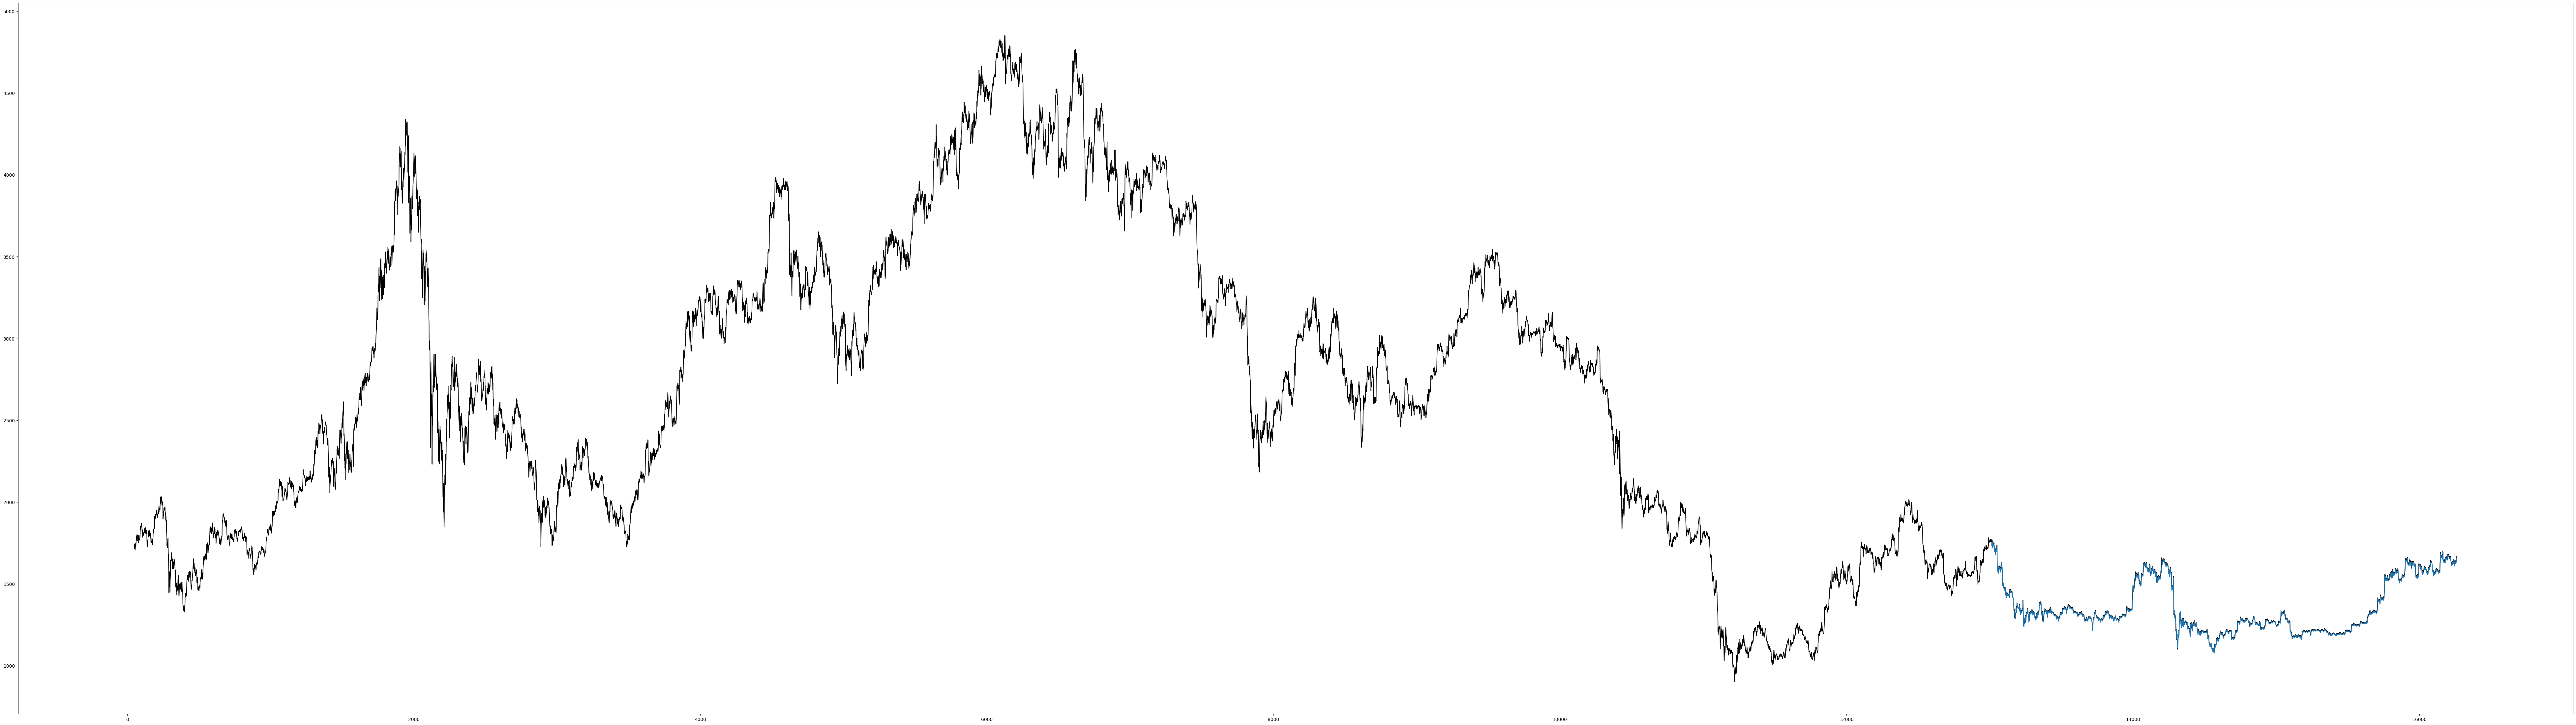

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 28))

plt.plot(data['close'], color='black')
plt.plot(y_test['pred'])
plt.show()

### with backup data

In [13]:
from talib import RSI
data_backup['rsi_14'] = RSI(data_backup['close'], timeperiod=14)
data_backup['rsi_14'] = data_backup['rsi_14'].shift(1)

from talib import MA, SMA, EMA
data_backup['ma_9'] = MA(data_backup['close'], timeperiod=9)
data_backup['ma_9'] = data_backup['ma_9'].shift(1)

from talib import MACD
data_backup['macd'], data_backup['signal'], data_backup['hist'] = MACD(data_backup['close'])
data_backup['macd'] = data_backup['macd'].shift(1)
data_backup['signal'] = data_backup['signal'].shift(1)
data_backup['hist'] = data_backup['hist'].shift(1)

from talib import ADX
data_backup['adx'] = ADX(data_backup['high'], data_backup['low'], data_backup['close'])
data_backup['adx'] = data_backup['adx'].shift(1)

data_backup.dropna(axis=0, inplace=True)

data_backup['close+'] = data_backup['close'].shift(1)

data_backup['close_roc'] = ( data_backup['close'] - data_backup['close'].shift(1) ) / data_backup['close'].shift(1)
data_backup['close_roc'] = data_backup['close_roc'].shift(1)
data_backup['rsi_14_roc'] = ( data_backup['rsi_14'] - data_backup['rsi_14'].shift(1) ) / data_backup['rsi_14'].shift(1)
data_backup['rsi_14_roc'] = data_backup['rsi_14_roc'].shift(1)
data_backup['ma_9_roc'] = ( data_backup['ma_9'] - data_backup['ma_9'].shift(1) ) / data_backup['ma_9'].shift(1)
data_backup['ma_9_roc'] = data_backup['ma_9_roc'].shift(1)

data_backup['close_roll'] = data_backup['close+'].rolling(window=14).mean()
data_backup['rsi_14_roll'] = data_backup['rsi_14'].rolling(window=14).mean()
data_backup['ma_9_roll'] = data_backup['ma_9'].rolling(window=14).mean()

data_backup.dropna(axis=0, inplace=True)

In [14]:
inputs_backup = data_backup[list(best_features)]
target_backup = data_backup.iloc[:, [5]]

pred_backup = model.predict(inputs_backup)

252/252 [==============================] - 1s 4ms/step


In [15]:
raw_data_backup = data_backup.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
raw_data_backup['pred'] = pred_backup
#raw_data_backup['pred'] = raw_data_backup['pred'].shift(1)

/tmp/ipykernel_1596201/1151946551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_backup['pred'] = pred_backup


In [16]:
score_backup = mean_squared_error(target_backup, pred_backup)
print(score_backup)

156.69267461442624


In [17]:
raw_data_backup.to_excel('raw_data_best_features-close.xlsx')

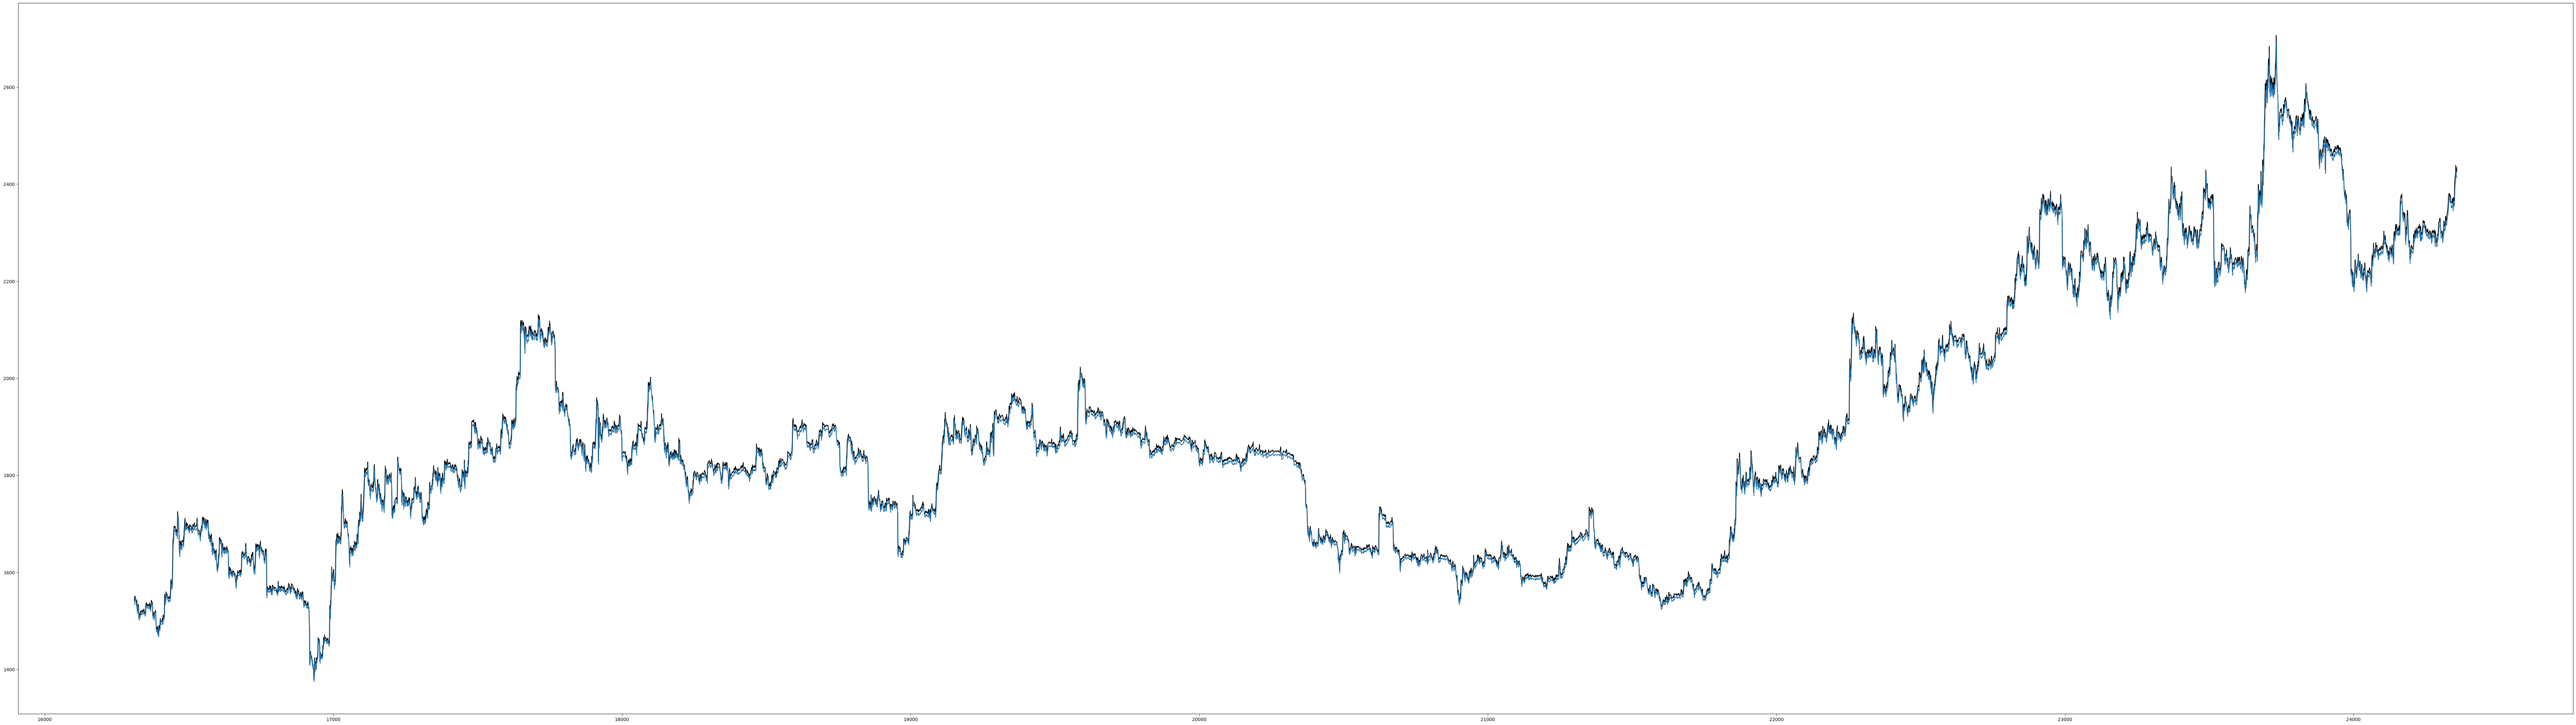

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 28))

plt.plot(data_backup['close'], color='black')
plt.plot(raw_data_backup['pred'])
plt.show()